# Flair Intership: Implementation of Encoder-Decoder techniques for Forecasting of levels of $CO_2$ using data collected from Airly devices

## **Author**: Ignacio Acevedo

In [2]:
# libraries and modules used through the implementation and analysis code

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from datetime import datetime, timedelta

# libraries and modules specialized in deep learning

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial import distance
from timeit import default_timer as timer
from torch.utils.data import random_split

# Load data

In [2]:
# general function to generate sequences of time series

def tseries_gen(data, deltaT, Lmin, Lmax, Lf, max_gap=500*1E+03, output=['co2'], N=20):
  '''
    Args:
            data (DataFrame): data with the features of the device for the input.
            deltaT (list/serie): list of the times from the last sample measured by the device.
            Lmin (int): minimum length of the input time serie.
            Lmax (int): maximum length of the input time serie.
            Lf (int): length of the time serie to predict.
            max_gap (float) : maximum value of the difference of time between samples.
            output (str) : feature to predict in the output.
            N (int) : Number of samples of time series with length between [Lmin, Lmax].
    
    Return: List of time series samples in the following structure
            input_enc, input_dec, output_dec
            where 'input_enc' is a list of features from 'data' with length between [Lmin, Lmax]. 'input_dec'
            is the difference of times of 'output_dec' and 'output_dec' is the time serie to predict.
    '''
  input_enc = []
  input_dec = []
  output_dec = []
  index = np.random.randint(Lmin, Lmax, size=N)
  for i in range(len(data)-Lmax-Lf):
    for j in index:
      if (deltaT[i:i+j+Lf] < max_gap).all():
        # seqs_enc.append([data[i:i+j], deltaT[i:i+j]])
        input_enc.append(data[i:i+j])
        input_dec.append(deltaT[i+j:i+j+Lf])
        output_dec.append(data[i+j:i+j+Lf][output]) #, deltaT[i+j:i+j+Lf]])
  
  return input_enc, input_dec, output_dec

In [ ]:
# # Aqui descargamos algunas funciones utiles para resolver la tarea y entrenar los modelos
# if not os.path.exists('utils.py'):
#   !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea4/utils.py

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/7mo año/Práctica 2022/Data/data.csv'
df = pd.read_csv(path, index_col='time')

In [5]:
df.head()

,sample_time,device_id,temperature,humidity,co2,hour,day_name,location,location_id,workday,dt_device,dt_location
time,,,,,,,,,,,,
2021-08-04 16:09:38.272,1628107778272,gam-01,22.1,36,719,16.160556,Wednesday,gam,1,True,139239.0,67483.0
2021-08-04 16:11:10.627,1628107870627,gam-01,22.2,35,670,16.186111,Wednesday,gam,1,True,92355.0,92355.0
2021-08-04 16:12:07.277,1628107927277,gam-01,22.2,35,667,16.201944,Wednesday,gam,1,True,56650.0,56650.0
2021-08-04 16:13:04.394,1628107984394,gam-01,22.3,34,648,16.217778,Wednesday,gam,1,True,57117.0,57117.0
2021-08-04 16:14:01.490,1628108041490,gam-01,22.3,34,636,16.233611,Wednesday,gam,1,True,57096.0,57096.0


# Encode categorical variables and generate time series

In [6]:
df.drop(columns=['sample_time', 'dt_location', 'location_id'], inplace=True)

In [7]:
# One hot encoding for categorical variables

df.drop(columns=['day_name'], inplace=True)
df = pd.get_dummies(df, columns=['location', 'workday'])
df.index = pd.to_datetime(df.index)
df.head()

,device_id,temperature,humidity,co2,hour,dt_device,location_gam,location_hcm,workday_False,workday_True
time,,,,,,,,,,
2021-08-04 16:09:38.272,gam-01,22.1,36,719,16.160556,139239.0,1,0,0,1
2021-08-04 16:11:10.627,gam-01,22.2,35,670,16.186111,92355.0,1,0,0,1
2021-08-04 16:12:07.277,gam-01,22.2,35,667,16.201944,56650.0,1,0,0,1
2021-08-04 16:13:04.394,gam-01,22.3,34,648,16.217778,57117.0,1,0,0,1
2021-08-04 16:14:01.490,gam-01,22.3,34,636,16.233611,57096.0,1,0,0,1


# Generate Time Series Data

In [8]:
mask = (df.device_id == 'hcm-15')
data = df[mask]

In [9]:
# Normalization
# We could use scalar scikit-learn functions here

filter_data = data[data['dt_device'] < data.dt_device.quantile([0.99]).item()]

mu = [filter_data[feature].mean() for feature in ['temperature', 'humidity', 'co2', 'hour', 'dt_device']]
sigma = [filter_data[feature].std() for feature in ['temperature', 'humidity', 'co2', 'hour', 'dt_device']]

for feature in ['temperature', 'humidity', 'co2', 'hour', 'dt_device']:
  mean = filter_data[feature].mean()
  std = filter_data[feature].std()
  data[feature] -= mean
  data[feature] /= std

  mu.append(mean)
  sigma.append(std)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [10]:
data.head()

,device_id,temperature,humidity,co2,hour,dt_device,location_gam,location_hcm,workday_False,workday_True
time,,,,,,,,,,
2021-10-14 14:20:38.702,hcm-15,-1.84859,0.532306,1.054624,0.354984,-0.692303,0,1,0,1
2021-10-14 14:21:27.406,hcm-15,-1.84859,0.532306,0.991817,0.356907,-0.980406,0,1,0,1
2021-10-14 14:24:53.950,hcm-15,-1.84859,0.532306,1.180238,0.364995,1.874217,0,1,0,1
2021-10-14 14:28:31.098,hcm-15,-1.84859,0.532306,1.067185,0.373553,2.065996,0,1,0,1
2021-10-14 14:29:37.485,hcm-15,-1.84859,0.532306,1.067185,0.376144,-0.660599,0,1,0,1


In [11]:
deltaT = data.dt_device
data = data.drop(columns=['device_id'])

Lmin = 90 # \approx 1 hour and a half
Lmax = 180 # \approx 3 hours
Lf = 30 # \approx 30 minutes
max_gap = deltaT.quantile([0.99]).item()

input_enc_test1, input_dec_test1, output_test1 = tseries_gen(data, deltaT, Lmin, Lmax, Lf, max_gap=max_gap, N=10)


In [12]:
print(f'total length of the serie: {len(data)}')
print(f'total length of the future real CO2 value: {len(output_test1)}')
print(f'time series with random length from {Lmin} to {Lmax}, and predicted length of {Lf}:', len(input_enc_test1))
print('number of devices:', len(df.device_id.unique()))

total length of the serie: 37518
total length of the future real CO2 value: 214974
time series with random length from 90 to 180, and predicted length of 30: 214974
number of devices: 49


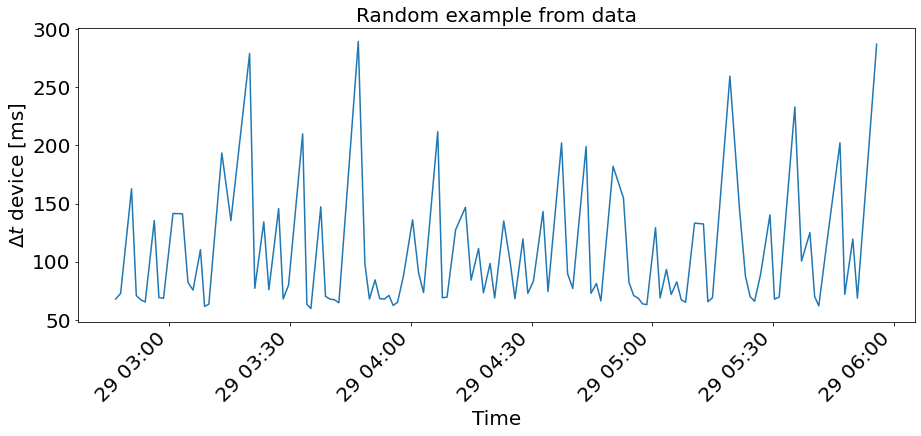

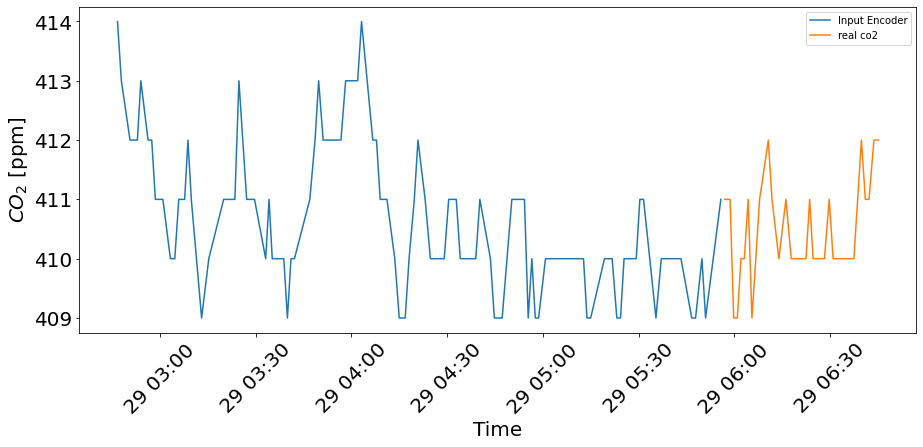

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))
index = np.random.randint(len(input_enc_test1))
((sigma[-1]*input_enc_test1[index] + mu[-1]).dt_device / 1000).plot(y='$\\Delta t$ device [ms]', ax=ax, label=f'serie {index}')
plt.xticks(rotation=45)
handles, labels = ax.get_legend_handles_labels()
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_title('Random example from data', fontsize=20)
ax.set_ylabel('$\\Delta t$ device [ms]', fontsize=20)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot((sigma[2]*input_enc_test1[index] + mu[2]).co2, label='Input Encoder')
ax.plot((sigma[2]*output_test1[index] + mu[2]), label='real co2')
plt.xticks(rotation=45)
handles, labels = ax.get_legend_handles_labels()
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.legend()
ax.set_ylabel('$CO_2$ [ppm]', fontsize=20);

# Custom Dataset

In [14]:
# we pass data to numpy arrays

input_enc_test = [torch.tensor(np.asarray(xserie), dtype=torch.float) for xserie in input_enc_test1]
input_dec_test = [torch.tensor(np.asanyarray(serie).reshape(-1, 1), dtype=torch.float) for serie in input_dec_test1]
labels_test = [torch.tensor(np.asanyarray(serie).reshape(-1, 1), dtype=torch.float) for serie in output_test1]

In [15]:
def collate_seqs(batch):
    input_enc, input_dec, targets = [], [], []
    
    for x, deltat, y in batch:
        input_enc.append(x)
        input_dec.append(deltat)
        targets.append(y)
    input_enc = pack_sequence(input_enc, enforce_sorted=False)
    input_dec = torch.stack(input_dec, dim=0)
    targets = torch.stack(targets, dim=0)


    return [input_enc, input_dec, targets]

In [16]:
class TSeriesDataset(Dataset):
  def __init__(self, data_enc, data_dec, target):
    self.Y = target
    self.data_enc = data_enc
    self.data_dec = data_dec
    # self.deltaTdecoder = features[:][1]
  
  def __len__(self):
    return len(self.Y)
  
  def __getitem__(self, idx):
    X = self.data_enc[idx] # torch.tensor(self.data_enc[idx], dtype=torch.float)
    deltaT_dec = self.data_dec[idx] # torch.tensor(self.data_dec[idx], dtype=torch.float)#.view(-1, 1)
    Y = self.Y[idx] # torch.tensor(self.Y[idx], dtype=torch.float)#.view(-1, 1)

    return X, deltaT_dec, Y

In [18]:
# test

dataset = TSeriesDataset(data_enc=input_enc_test, data_dec=input_dec_test, target=labels_test)
for i in range(len(dataset)):
    x, deltat, y = dataset[i]
    # print(x, '\n', deltat, '\n', y)
    if i == 0: break

In [ ]:
loader_test = DataLoader(dataset, batch_size=10, collate_fn=collate_seqs)
for idx, batch in enumerate(loader_test):
    x, deltat, y = batch
    break

# print(x)

# Encoder

In [20]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pack_sequence, pad_packed_sequence

In [21]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers=1, dropout=0, batch_first=True):
    super(EncoderRNN, self).__init__()
    # self.num_layers = num_layers

    self.hidden_size = hidden_size
    # self.embedding = nn.Embedding(input_size, hidden_size)
    self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, dropout=dropout,
                      batch_first=batch_first)

  def forward(self, input, hidden=None):
    '''
      Args:
            input (Tensor or PackedSequence)
            hidden (Tensor)
    '''
    
    # output: B x L* x H; hidden: 1 x B x H
    # output_seqs: packed_data (B x L x H), packed_batches (L)
    if hidden is None: # delete None and if using torch.zeros 
      output, hidden = self.rnn(input)
    else:
      output, hidden = self.rnn(input, hidden)
    
    return output, hidden
  
  # def initHidden(self):
  #   return torch.zeros(self.num_layers, max_length)


- We could do batch normalization for each layer of RNN (search for it). Answer: Too complicated (check https://arxiv.org/pdf/1603.09025.pdf and https://github.com/jihunchoi/recurrent-batch-normalization-pytorch/blob/master/bnlstm.py)

# Decoder

In [22]:
class DecoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0, batch_first=True):
    super(DecoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=batch_first)
    self.out = nn.Linear(hidden_size, output_size)
    
  def forward(self, input, hidden=None):
    # input: deltaT
    # output = F.relu(input)

    if hidden is None: # delete None and if using torch.zeros 
      # output: B* x L* x H; hidden: 1 x B x H
      output, hidden = self.rnn(input)
    
    else:
      # output: B* x L* x H; hidden: 1 x B x H
      output, hidden = self.rnn(input, hidden)
    
    # output: B* x L* x output_size
    output = self.out(output)
    return output, hidden


# Encoder-Decoder Model

- Encoder input $X_{features}$
- Decoder input $\Delta t$

In [23]:
class Model1(nn.Module):
  def __init__(self, input_size_enc, hidden_size_enc, input_size_dec, hidden_size_dec, output_size,
               num_layers=[1, 1], dropout=[0, 0], batch_first=True):
    super(Model1, self).__init__()

    # keep for reference
    self.input_size_enc = input_size_enc
    self.hidden_size_enc = hidden_size_enc
    self.hidden_size_dec = hidden_size_dec
    self.input_size_dec = input_size_dec
    self.output_size = output_size
    self.num_layers = num_layers
    self.dropout = dropout
    self.batch_first = batch_first

    self.encoder = EncoderRNN(input_size_enc, hidden_size_enc, num_layers=num_layers[0], dropout=dropout[0],
                              batch_first=batch_first)
    self.decoder = DecoderRNN(input_size_dec, hidden_size_dec, output_size,
                              num_layers=num_layers[1], dropout=dropout[1], batch_first=batch_first)

  def forward(self, input_enc, input_dec, hidden=None): # change None in hidden

    # output: B* x length_enc* x H ; hidden: 1 x B x H
    output, hidden = self.encoder(input_enc, hidden)

    # output: B x length_dec x H; hiddden: 1 x B x H
    output, hidden = self.decoder(input_dec, hidden)

    return output

  def num_parameters(self):
    total = 0
    for p in self.parameters():
      if p.requires_grad:
        total += p.numel()
    return total


# Training

In [24]:
from torch._C import default_generator
def train(model, dataset, optimizer, epochs=1, batch_size=1, device='cpu', val_split=0.8,
          random_seed=42, reports_every=1, model_name='Model', report_batch=True, pin_memory=False, collate_fn=collate_seqs):
  
  # change the model to device
  model.to(device)

  # show the model arquitecture
  print(model_name, model)

  # Print number of parameters
  print('Num Params:', model.num_parameters())

  # Create a dataloader from the dataset
  train_size = int(val_split * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, val_dataset = random_split(dataset, [train_size, test_size],
                                            generator=torch.Generator().manual_seed(random_seed))

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                            collate_fn=collate_fn, pin_memory=pin_memory)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, 
                            collate_fn=collate_fn, pin_memory=pin_memory)

  # Define a Loss Function
  LossFunction = torch.nn.MSELoss()

  # Lists for training and evaluation loss functions per epoch
  train_loss, val_loss = [], []

  # Lists for training and evaluation loss functions per batch
  if report_batch:
    loss_batch = []
    num_upgrade  = []

  # Start training
  time_epochs = 0.
  for e in range(1, epochs+1):
    beginning_epoch = timer()
    
    running_loss = 0.
    model.train()
    for idx, batch in enumerate(train_loader):
      x, deltat, y = batch

      # Make sure tensors used are in the device with correct dimensions
      x, deltat, y = x.float().to(device), deltat.to(device), y.to(device)

      # Compute forward
      y_pred  = model(x, deltat)

      # Compute the loss
      loss = LossFunction(y_pred, y)

      # Backprop
      loss.backward()

      # Update grad
      optimizer.step()
      optimizer.zero_grad()

      running_loss += loss.item()

      if report_batch and (idx % 100 == 0):
            report_loss, current = loss.item(), idx * batch_size
            print(f" current loss: {report_loss:.4e}  [{current:>5d}/{train_size:>5d}]")
            # sys.stdout.write(f" current loss: {report_loss:.4e}  [{current:>6d}/{train_size:>6d}] \n"
            # )

            loss_batch.append(report_loss)
            num_upgrade.append((e - 1) * train_size + current)

    mean_loss = running_loss / (idx + 1)
    train_loss.append(mean_loss)

    running_loss = 0.
    model.eval()
    with torch.no_grad():
      for idx, batch in enumerate(val_loader):
        x, deltat, y = batch

        # Make sure tensors used are in the device with correct dimensions
        x, deltat, y = x.float().to(device), deltat.to(device), y.to(device)

        # Compute forward
        y_pred  = model(x, deltat)

        # Compute the loss
        loss = LossFunction(y_pred, y)

        running_loss += loss.item()
    mean_loss = running_loss / (idx + 1)
    val_loss.append(mean_loss)
    
    time_epochs += timer() - beginning_epoch
    
    # Report the number of right answers each "reports_every" amount of epochs
    if e % reports_every == 0:
      print('\rEpoch:{0:03d}'.format(e) + ' Train Loss:{0:.4e}'.format(train_loss[-1]) 
          + ' Val Loss:{0:.4e}'.format(val_loss[-1]) + ' Time/epoch:{0:.3f}s'.format(time_epochs/e))
      # sys.stdout.write(
      #     '\rEpoch:{0:03d}'.format(e) + ' Train Loss:{0:.4e}'.format(train_loss[-1]) 
      #     + ' Val Loss:{0:.4e}'.format(val_loss[-1]) + ' Time/epoch:{0:.3f}s'.format(time_epochs/e) + '\n'
      # )
  
  if report_batch:
    return train_loss, val_loss, loss_batch, num_upgrade
  else:
    return train_loss, val_loss


# Testing the training function and model

In [ ]:
class RandomDataSet(Dataset):
  def __init__(self, N, L, f):
    
    self.input_enc = torch.rand(N, L, f)
    self.input_dec = torch.rand(N, L, 1)
    self.Y = torch.rand(N, L, 1)
    self.num_features = f
    
  # Debemos definir __len__ para retornar el tamaño del dataset
  def __len__(self):
    return self.input_enc.size()[0]

  # Debemos definir __getitem__ para retornar el i-ésimo 
  # ejemplo en nuestro dataset.
  def __getitem__(self, i):
    return self.input_enc[i], self.input_dec[i], self.Y[i]

In [ ]:
N = 1000 # numero de ejemplos
f = 9 # numero de features
L = 100

dataset = RandomDataSet(N, L, f)

In [ ]:
model = Model1(9, 64, 1, 64, 1)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train_loss, val_loss = train(model, dataset, optimizer, epochs=10, batch_size=16)

Model Model1(
  (encoder): EncoderRNN(
    (rnn): RNN(9, 64)
  )
  (decoder): DecoderRNN(
    (rnn): RNN(1, 64)
    (out): Linear(in_features=64, out_features=1, bias=True)
  )
)
Num Params: 9153


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100, 16, 1])) that is different to the input size (torch.Size([100, 16, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 100, 1])) that is different to the input size (torch.Size([1, 100, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:010 Train Loss:0.0836 Val Loss:0.1512 Time/epoch:2.096s

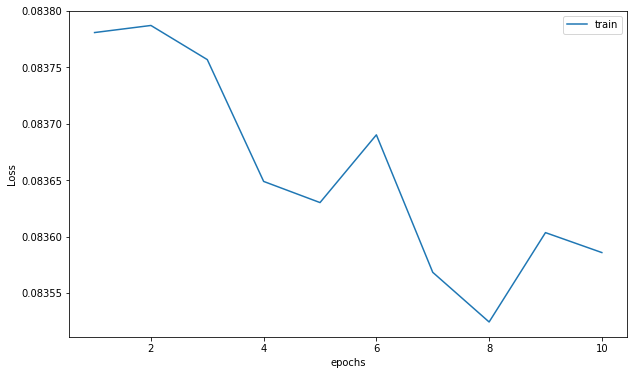

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
epochs = np.arange(1, 11)
ax.plot(epochs, train_loss, label='train')
# ax.plot(epochs, val_loss, label='val')
ax.set_xlabel('epochs')
ax.set_ylabel('Loss')
ax.legend()


## Comparing methods to pack batches in Pytorch

- `torch.nn.utils.rnn.pad_sequence`: pads a sequence of tensors
- `torch.nn.utils.rnn.pack_padded_sequence`: packs a padded sequence of tensors (it needs their lengths)
- `torch.nn.utils.rnn.pack_sequence`: packs a sequence of tensors (using the above functions as shown below)

```
lengths = torch.as_tensor([v.size(0) for v in sequences])
    return pack_padded_sequence(pad_sequence(sequences), lengths,
    enforce_sorted=enforce_sorted)
```

- `torch.nn.utils.rnn.pad_packed_sequence`: pads a packed batch of variable length sequences.

Note: the input `enforce_sorted=True` is only necessary for ONNX export.

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pack_sequence, pad_packed_sequence

seq_batch = [torch.tensor([[1, 1],
                           [2, 2],
                           [3, 3],
                           [4, 4],
                           [5, 5]]),
             torch.tensor([[10, 10],
                           [20, 20]])]

seq_lens = [5, 2]
padded_seq = pad_sequence(seq_batch)
packed_padded_seq = pack_padded_sequence(padded_seq, lengths=seq_lens)
packed_seq = pack_sequence(seq_batch)
padded_packed_seq = pad_packed_sequence(packed_padded_seq, total_length=5)

In [ ]:
unpacked, unpacked_len = padded_packed_seq

In [ ]:
packed_padded_seq

PackedSequence(data=tensor([[ 1,  1],
        [10, 10],
        [ 2,  2],
        [20, 20],
        [ 3,  3],
        [ 4,  4],
        [ 5,  5]]), batch_sizes=tensor([2, 2, 1, 1, 1]), sorted_indices=None, unsorted_indices=None)

In [ ]:
unpacked

tensor([[[ 1,  1],
         [10, 10]],

        [[ 2,  2],
         [20, 20]],

        [[ 3,  3],
         [ 0,  0]],

        [[ 4,  4],
         [ 0,  0]],

        [[ 5,  5],
         [ 0,  0]]])

In [ ]:
(unpacked_len - 1).long()

tensor([4, 1])

In [ ]:
unpacked.index_select(dim=0, index=(unpacked_len - 1).long())

tensor([[[ 5,  5],
         [ 0,  0]],

        [[ 2,  2],
         [20, 20]]])

In [ ]:
packed_padded_seq.batch_sizes.index_select(dim=0, index=(unpacked_len - 1).long())

tensor([1, 2])

In [ ]:
indices = Variable(torch.LongTensor(np.array(unpacked_len) - 1).view(-1, 1)
                                                                       .expand(unpacked.size(0), unpacked.size(2))
                                                                       .unsqueeze(1))
last_encoded_states = unpacked.gather(dim=1, index=indices).squeeze(dim=1)

In [ ]:
padded_packed_seq[1]

tensor([5, 2])

In [ ]:
padded_packed_seq[0][]

tensor([[[ 1,  1],
         [10, 10]],

        [[ 2,  2],
         [20, 20]],

        [[ 3,  3],
         [ 0,  0]],

        [[ 4,  4],
         [ 0,  0]],

        [[ 5,  5],
         [ 0,  0]]])

In [ ]:
x1, _ = dataset.__getitem__(idx=1)
x2, _ = dataset.__getitem__(idx=2)
seq = [x1, x2]
packed_seq = pack_sequence(seq, enforce_sorted=False)

In [ ]:
packed_seq

PackedSequence(data=tensor([[ 0.5554, -0.4929, -0.0162,  ...,  1.0000,  0.0000,  1.0000],
        [ 0.5554, -0.4929, -0.0162,  ...,  1.0000,  0.0000,  1.0000],
        [ 0.5554, -0.4929, -0.0162,  ...,  1.0000,  0.0000,  1.0000],
        ...,
        [ 0.3693,  0.0924, -0.0163,  ...,  1.0000,  0.0000,  1.0000],
        [ 0.3693,  0.0924, -0.0163,  ...,  1.0000,  0.0000,  1.0000],
        [ 0.3693,  0.0924, -0.0163,  ...,  1.0000,  0.0000,  1.0000]]), batch_sizes=tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), sorted_indices=tensor([0, 1]), unsorted_indices=tensor([0, 1]))

In [ ]:
rnn = nn.RNN(9, 128)
output, hn = rnn(packed_seq)

In [ ]:
x1.unsqueeze(dim=0).shape

torch.Size([1, 95, 9])

In [ ]:
output, hn = rnn(x1.unsqueeze(dim=0))
hn.shape

torch.Size([1, 95, 128])

In [ ]:
output

PackedSequence(data=tensor([[-0.0030,  0.0028,  0.0585,  ...,  0.0427, -0.1417, -0.0097],
        [-0.0030,  0.0028,  0.0585,  ...,  0.0427, -0.1417, -0.0097],
        [ 0.0466, -0.1255,  0.0698,  ...,  0.1718, -0.2161,  0.0509],
        ...,
        [ 0.1011, -0.0162,  0.0602,  ...,  0.2739, -0.1942, -0.0034],
        [ 0.1011, -0.0161,  0.0601,  ...,  0.2738, -0.1941, -0.0033],
        [ 0.1011, -0.0159,  0.0601,  ...,  0.2739, -0.1941, -0.0032]],
       grad_fn=<CatBackward0>), batch_sizes=tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]), sorted

In [ ]:
from io import StringIO

StringData = StringIO("""PERÍODO REMUNERACIÓN_IMPONIBLE_($) RUT_EMPLEADOR RAZÓN_SOCIAL_EMPLEADOR FONDO
04/2021 133.757 88.926.100-5 Paisajismo_Cordillera_S.A. E
07/2020 624.911 81.826.800-9 Caja_De_Com_De_Asignacion_Familiar_Los_Andes E
04/2020 323.943 88.926.100-5 Paisajismo_Cordillera_S.A. C
03/2020 440.955 88.926.100-5 Paisajismo_Cordillera_S.A. C
02/2020 624.911 88.926.100-5 Paisajismo_Cordillera_S.A. C
01/2020 646.311 88.926.100-5 Paisajismo_Cordillera_S.A. C
12/2019 517.911 88.926.100-5 Paisajismo_Cordillera_S.A. C
11/2019 539.311 88.926.100-5 Paisajismo_Cordillera_S.A. C
10/2019 539.311 88.926.100-5 Paisajismo_Cordillera_S.A. C
09/2019 614.311 88.926.100-5 Paisajismo_Cordillera_S.A. C
08/2019 517.911 88.926.100-5 Paisajismo_Cordillera_S.A. C
07/2019 518.211 88.926.100-5 Paisajismo_Cordillera_S.A. C
06/2019 539.311 88.926.100-5 Paisajismo_Cordillera_S.A. C
05/2019 451.178 88.926.100-5 Paisajismo_Cordillera_S.A. C
04/2019 539.311 88.926.100-5 Paisajismo_Cordillera_S.A. C
03/2019 539.311 88.926.100-5 Paisajismo_Cordillera_S.A. C
02/2019 525.933 88.926.100-5 Paisajismo_Cordillera_S.A. C
01/2019 504.533 88.926.100-5 Paisajismo_Cordillera_S.A. C
12/2018 547.333 88.926.100-5 Paisajismo_Cordillera_S.A. C
11/2018 525.933 88.926.100-5 Paisajismo_Cordillera_S.A. C
10/2018 483.133 88.926.100-5 Paisajismo_Cordillera_S.A. C
09/2018 547.333 88.926.100-5 Paisajismo_Cordillera_S.A. C
08/2018 483.133 88.926.100-5 Paisajismo_Cordillera_S.A. C
07/2018 525.933 88.926.100-5 Paisajismo_Cordillera_S.A. C
06/2018 483.133 88.926.100-5 Paisajismo_Cordillera_S.A. C
05/2018 525.933 88.926.100-5 Paisajismo_Cordillera_S.A. C
04/2018 327.000 88.926.100-5 Paisajismo_Cordillera_S.A. C
03/2018 401.266 88.926.100-5 Paisajismo_Cordillera_S.A. C
02/2018 611.533 88.926.100-5 Paisajismo_Cordillera_S.A. C
01/2018 611.533 88.926.100-5 Paisajismo_Cordillera_S.A. C
10/2017 101.250 99.503.010-1 Help_Security_S.A. C
09/2017 427.500 99.503.010-1 Help_Security_S.A. C
08/2017 646.875 99.503.010-1 Help_Security_S.A. C
07/2017 631.875 99.503.010-1 Help_Security_S.A. C
06/2017 608.500 99.503.010-1 Help_Security_S.A. C
05/2017 523.500 99.503.010-1 Help_Security_S.A. C
04/2017 393.166 99.503.010-1 Help_Security_S.A. C
03/2017 390.600 99.503.010-1 Help_Security_S.A. C
02/2017 440.649 99.503.010-1 Help_Security_S.A. C
01/2017 440.649 99.503.010-1 Help_Security_S.A. C
12/2016 480.724 99.503.010-1 Help_Security_S.A. C
11/2016 430.724 99.503.010-1 Help_Security_S.A. C
10/2016 423.213 99.503.010-1 Help_Security_S.A. C
09/2016 486.989 99.503.010-1 Help_Security_S.A. C
08/2016 441.989 99.503.010-1 Help_Security_S.A. B
07/2016 441.989 99.503.010-1 Help_Security_S.A. B
06/2016 430.208 99.503.010-1 Help_Security_S.A. B
05/2016 430.208 99.503.010-1 Help_Security_S.A. B
04/2016 422.916 99.503.010-1 Help_Security_S.A. B
03/2016 399.583 99.503.010-1 Help_Security_S.A. B
02/2016 422.916 99.503.010-1 Help_Security_S.A. B
01/2016 411.250 99.503.010-1 Help_Security_S.A. B
12/2015 447.916 99.503.010-1 Help_Security_S.A. B
11/2015 433.854 99.503.010-1 Help_Security_S.A. B
10/2015 426.561 99.503.010-1 Help_Security_S.A. B
09/2015 447.916 99.503.010-1 Help_Security_S.A. B
08/2015 433.854 99.503.010-1 Help_Security_S.A. B
07/2015 10.709 77.198.310-3 Soc._De_Servicios_Maxima_Seguridad_Operativa_Ltda. B
07/2015 128.334 99.503.010-1 Help_Security_S.A. B
06/2015 118.750 76.688.860-7 Servicios_Y_Seguridad_Cosenza_Limitada B
05/2015 707.063 76.688.860-7 Servicios_Y_Seguridad_Cosenza_Limitada B
04/2015 730.563 76.688.860-7 Servicios_Y_Seguridad_Cosenza_Limitada B
03/2015 115.875 76.688.860-7 Servicios_Y_Seguridad_Cosenza_Limitada B
03/2015 51.463 76.733.350-1 Servicios_Helpbank_S.A_E.S.T B
02/2015 151.508 76.733.350-1 Servicios_Helpbank_S.A_E.S.T B
01/2015 133.125 76.733.350-1 Servicios_Helpbank_S.A_E.S.T B
07/2014 363.434 77.508.190-2 Recursos_Externos_Ltda B
06/2014 503.820 77.508.190-2 Recursos_Externos_Ltda B
05/2014 456.739 77.508.190-2 Recursos_Externos_Ltda B
04/2014 282.403 77.508.190-2 Recursos_Externos_Ltda B
03/2014 442.612 77.508.190-2 Recursos_Externos_Ltda B
02/2014 401.984 77.508.190-2 Recursos_Externos_Ltda B
01/2014 336.991 77.508.190-2 Recursos_Externos_Ltda B
12/2013 381.359 77.508.190-2 Recursos_Externos_Ltda B
11/2013 602.546 77.508.190-2 Recursos_Externos_Ltda B
10/2013 456.682 77.508.190-2 Recursos_Externos_Ltda B
09/2013 413.213 77.508.190-2 Recursos_Externos_Ltda B
08/2013 328.803 77.508.190-2 Recursos_Externos_Ltda B
07/2013 378.536 77.508.190-2 Recursos_Externos_Ltda B
06/2013 518.483 77.508.190-2 Recursos_Externos_Ltda B
05/2013 440.517 77.508.190-2 Recursos_Externos_Ltda B
04/2013 293.116 77.508.190-2 Recursos_Externos_Ltda B
""")

imposiciones = pd.read_csv(StringData, sep=' ')
imposiciones['REMUNERACIÓN_IMPONIBLE_($)'] = imposiciones['REMUNERACIÓN_IMPONIBLE_($)'] * 1000



In [ ]:
imposiciones.head()

,PERÍODO,REMUNERACIÓN_IMPONIBLE_($),RUT_EMPLEADOR,RAZÓN_SOCIAL_EMPLEADOR,FONDO
0,04/2021,133757.0,88.926.100-5,Paisajismo_Cordillera_S.A.,E
1,07/2020,624911.0,81.826.800-9,Caja_De_Com_De_Asignacion_Familiar_Los_Andes,E
2,04/2020,323943.0,88.926.100-5,Paisajismo_Cordillera_S.A.,C
3,03/2020,440955.0,88.926.100-5,Paisajismo_Cordillera_S.A.,C
4,02/2020,624911.0,88.926.100-5,Paisajismo_Cordillera_S.A.,C


In [ ]:
imposiciones['REMUNERACIÓN_IMPONIBLE_($)'].sum() / 120

299837.74166666664

# Training Model 1: Encoder-Decoder Forecasting

## Setting

- input encoder (L_in x f): temperature | humidity	| co2 |	hour |	dt_device |	location_gam |	location_hcm |	workday_False |	workday_True|
- input decoder (L_in x 1): dt_device
- output decoder (L_out x 1): co2
- L_in: variable length
- L_out: **30**

## Params architecture

- ``hidden_size_enc`` = 128
- ``hidden_size_dec`` = 128
- ``num_layers`` = [2, 2]
- ``dropout`` = [0.25, 0.25]
- ``batch_first`` = True
- ``optimizer`` = Adam(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=2e-04, amsgrad=False)
- ``batch_size`` = 200
- ``val_split`` = 0.8

In [40]:
dataset = TSeriesDataset(data_enc=input_enc_test, data_dec=input_dec_test, target=labels_test)

# Model
EncDecF = Model1(9, 128, 1, 128, 1, num_layers=[2, 2], dropout=[0.25, 0.25], batch_first=True)

# Optimizer
optimizer = torch.optim.Adam(EncDecF.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=2e-04, amsgrad=False)


## Training

In [41]:
epochs = 10
train_loss1, val_loss1, loss_batch1, num_upgrade1 = train(EncDecF, dataset, optimizer, epochs=epochs, batch_size=200,
                                                      device='cuda', val_split=0.8, reports_every=1, 
                                                      model_name='Raw Encoder-Decoder Forecasting', report_batch=True,
                                                      pin_memory=True)


Raw Encoder-Decoder Forecasting Model1(
  (encoder): EncoderRNN(
    (rnn): RNN(9, 128, num_layers=2, batch_first=True, dropout=0.25)
  )
  (decoder): DecoderRNN(
    (rnn): RNN(1, 128, num_layers=2, batch_first=True, dropout=0.25)
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)
Num Params: 100737
 current loss: 4.4793e-01  [    0/171979]
 current loss: 6.4308e-02  [20000/171979]
 current loss: 4.3749e-02  [40000/171979]
 current loss: 4.3478e-02  [60000/171979]
 current loss: 3.9152e-02  [80000/171979]
 current loss: 3.1791e-02  [100000/171979]
 current loss: 5.3446e-02  [120000/171979]
 current loss: 2.9628e-02  [140000/171979]
 current loss: 2.8333e-02  [160000/171979]
Epoch:001 Train Loss:4.8334e-02 Val Loss:3.5297e-02 Time/epoch:86.982s
 current loss: 4.6414e-02  [    0/171979]
 current loss: 2.8631e-02  [20000/171979]
 current loss: 3.0858e-02  [40000/171979]
 current loss: 2.5656e-02  [60000/171979]
 current loss: 3.6855e-02  [80000/171979]
 current loss: 2.7

## Plots

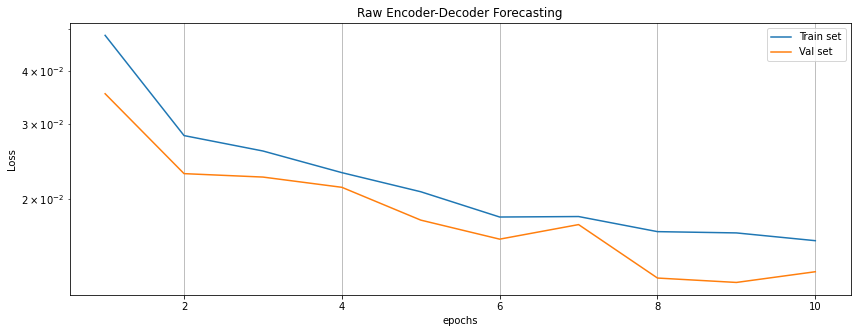

In [42]:
fig, ax = plt.subplots(figsize=(14, 5))
epochs_list = np.arange(1, epochs+1)
ax.set_yscale('log')
ax.plot(epochs_list, train_loss1, label='Train set')
ax.plot(epochs_list, val_loss1, label='Val set')
ax.set_xlabel('epochs')
ax.set_ylabel('Loss')
ax.set_title('Raw Encoder-Decoder Forecasting')
ax.legend()
ax.grid();

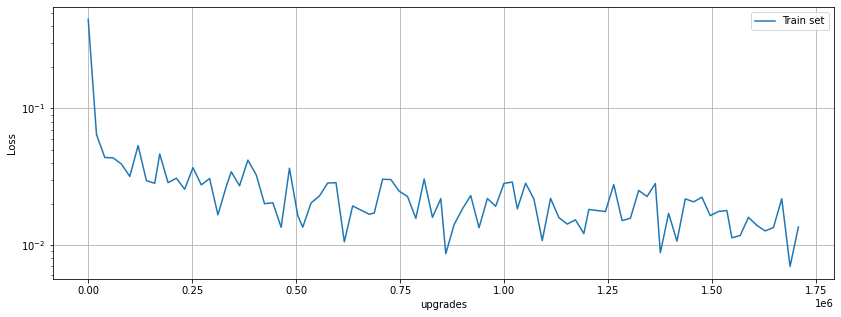

In [43]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(num_upgrade1, loss_batch1, label='Train set')
ax.set_yscale('log')
ax.set_xlabel('upgrades')
ax.set_ylabel('Loss')
ax.legend()
ax.grid();

In [49]:
# Testing random example:
EncDecF.to('cpu')

x, dt, y = dataset[np.random.randint(len(dataset))]
x, dt, y = collate_seqs([[x, dt, y]])
# x, dt, y = x.view(1, -1, 9), dt.view(1, -1, 1), y.view(1, -1).squeeze(dim=0)
y = y.view(1, -1).squeeze(dim=0)

y_pred = EncDecF(x, dt).squeeze(dim=0).squeeze(dim=1).to('cpu').detach().numpy()
dt = dt.squeeze(dim=0).squeeze(dim=1).to('cpu').numpy()

t0 = 0
tt = np.zeros(len(dt))
for i in range(len(dt)):
    t0 += sigma[-1]*dt[i] + mu[-1]
    tt[i] = t0
tt = tt / 1000


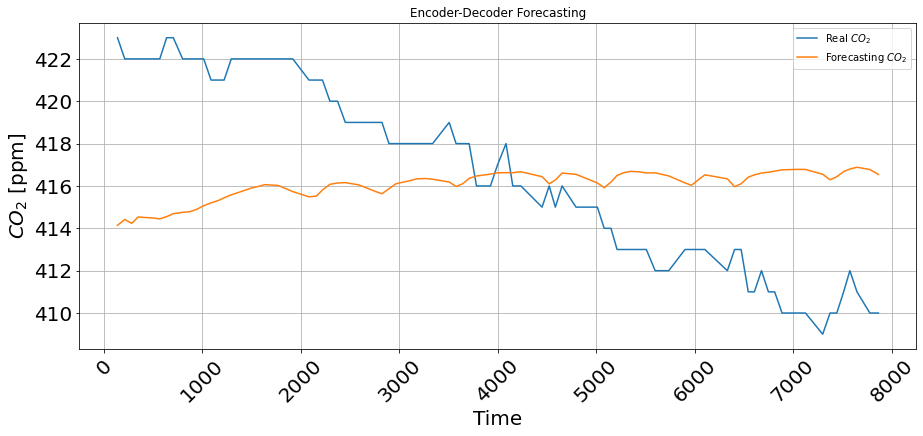

In [52]:
idx = 0
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(tt[idx:], (sigma[2]*y + mu[2])[idx:], label='Real $CO_2$')
ax.plot(tt[idx:], (sigma[2]*y_pred + mu[2])[idx:], label='Forecasting $CO_2$')
# ax.plot(tt[idx:], y[idx:], label='Real co2')
# ax.plot(tt[idx:], y_pred[idx:], label='Prediction co2')
plt.xticks(rotation=45)
handles, labels = ax.get_legend_handles_labels()
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_title('Encoder-Decoder Forecasting')
ax.legend()
ax.grid()
ax.set_ylabel('$CO_2$ [ppm]', fontsize=20);

# Training Model 1: Encoder-Decoder Duplicate (last 60) + Forescast

## Setting

- input encoder (L_in x f): temperature | humidity	| co2 |	hour |	dt_device |	location_gam |	location_hcm |	workday_False |	workday_True|
- input decoder (L_out x 1): dt_device
- output decoder (L_out x 1): co2
- L_in: variable length
- L_out: **L_in[-60:] + 30** = 90

## Params architecture

- ``hidden_size_enc`` = 128
- ``hidden_size_dec`` = 128
- ``num_layers`` = [2, 2]
- ``dropout`` = [0.25, 0.25]
- ``batch_first`` = True
- ``optimizer`` = Adam(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=2e-04, amsgrad=False)
- ``batch_size`` = 200
- ``val_split`` = 0.7


In [25]:
def collate_seqs(batch):
    input_enc, input_dec, targets = [], [], []
    
    for x, deltat, y in batch:
        input_enc.append(x)
        input_dec.append(torch.cat([x[:, 4][-60:].unsqueeze(dim=1), deltat], dim=0))
        targets.append(torch.cat([x[:, 2][-60:].unsqueeze(dim=1), y], dim=0))
    input_enc = pack_sequence(input_enc, enforce_sorted=False)
    input_dec = torch.stack(input_dec, dim=0)
    targets = torch.stack(targets, dim=0)

    return [input_enc, input_dec, targets]

In [26]:
dataset = TSeriesDataset(data_enc=input_enc_test, data_dec=input_dec_test, target=labels_test)

# Model
model = Model1(9, 128, 1, 128, 1, num_layers=[2, 2], dropout=[0.25, 0.25], batch_first=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=2e-04, amsgrad=False)


## Training the model

In [27]:
epochs = 10
train_loss2, val_loss2, loss_batch2, num_upgrade2 = train(model, dataset, optimizer, epochs=epochs, batch_size=200,
                                                      device='cuda', val_split=0.8, reports_every=1, 
                                                      model_name='Encoder-Decoder: Duplicate + Forecasting', 
                                                      report_batch=True, pin_memory=True)

Encoder-Decoder: Duplicate + Forecasting Model1(
  (encoder): EncoderRNN(
    (rnn): RNN(9, 128, num_layers=2, batch_first=True, dropout=0.25)
  )
  (decoder): DecoderRNN(
    (rnn): RNN(1, 128, num_layers=2, batch_first=True, dropout=0.25)
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)
Num Params: 100737
 current loss: 2.6746e-01  [    0/171979]
 current loss: 1.6846e-02  [20000/171979]
 current loss: 3.4998e-02  [40000/171979]
 current loss: 5.9051e-02  [60000/171979]
 current loss: 1.8862e-01  [80000/171979]
 current loss: 3.3901e-02  [100000/171979]
 current loss: 4.5549e-02  [120000/171979]
 current loss: 3.7527e-02  [140000/171979]
 current loss: 4.8647e-02  [160000/171979]
Epoch:001 Train Loss:5.2464e-02 Val Loss:3.8194e-02 Time/epoch:84.840s
 current loss: 4.0601e-02  [    0/171979]
 current loss: 6.1210e-02  [20000/171979]
 current loss: 3.5535e-02  [40000/171979]
 current loss: 3.0781e-02  [60000/171979]
 current loss: 3.5834e-02  [80000/171979]
 current 

## Plots

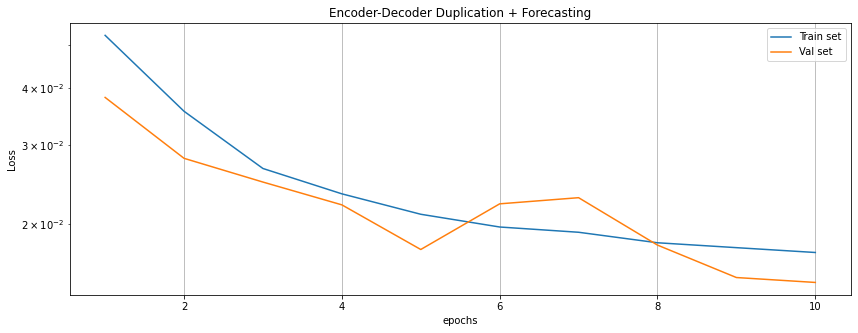

In [38]:
fig, ax = plt.subplots(figsize=(14, 5))
epochs = np.arange(1, epochs+1)
ax.set_yscale('log')
ax.plot(epochs, train_loss2, label='Train set')
ax.plot(epochs, val_loss2, label='Val set')
ax.set_xlabel('epochs')
ax.set_ylabel('Loss')
ax.set_title('Encoder-Decoder Duplication + Forecasting')
ax.legend()
ax.grid();

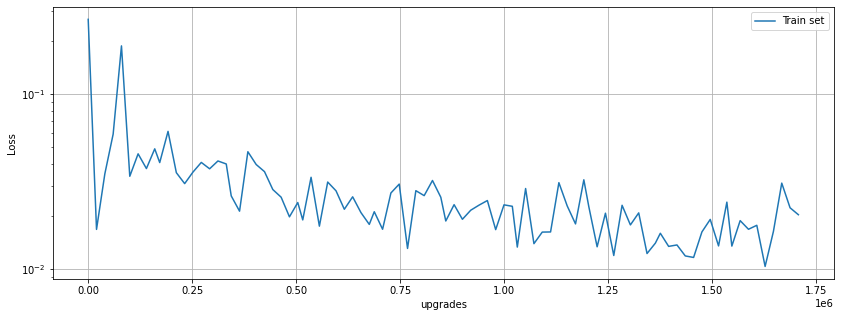

In [39]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(num_upgrade2, loss_batch2, label='Train set')
ax.set_yscale('log')
ax.set_xlabel('upgrades')
ax.set_ylabel('Loss')
ax.legend()
ax.grid();

In [54]:
# Testing random example:
model.to('cpu')

x, dt, y = dataset[np.random.randint(len(dataset))]
x, dt, y = collate_seqs([[x, dt, y]])
# x, dt, y = x.view(1, -1, 9), dt.view(1, -1, 1), y.view(1, -1).squeeze(dim=0)
y = y.view(1, -1).squeeze(dim=0)

y_pred = model(x, dt).squeeze(dim=0).squeeze(dim=1).to('cpu').detach().numpy()

dt = dt.squeeze(dim=0).squeeze(dim=1).to('cpu').numpy()

In [55]:
t0 = 0
tt = np.zeros(len(dt))
for i in range(len(dt)):
    t0 += sigma[-1]*dt[i] + mu[-1]
    tt[i] = t0
tt = tt / 1000

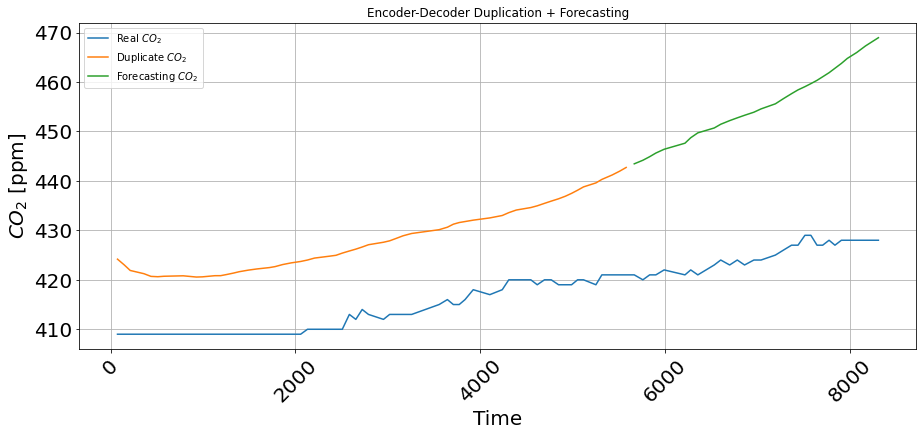

In [56]:
idx = 0
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(tt[idx:], (sigma[2]*y + mu[2])[idx:], label='Real $CO_2$')
ax.plot(tt[idx:-30], (sigma[2]*y_pred + mu[2])[idx:-30], label='Duplicate $CO_2$')
ax.plot(tt[-30:], (sigma[2]*y_pred + mu[2])[-30:], label='Forecasting $CO_2$')
# ax.plot(tt[idx:], y[idx:], label='Real co2')
# ax.plot(tt[idx:], y_pred[idx:], label='Prediction co2')
plt.xticks(rotation=45)
handles, labels = ax.get_legend_handles_labels()
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_title('Encoder-Decoder Duplication + Forecasting')
ax.legend()
ax.grid()
ax.set_ylabel('$CO_2$ [ppm]', fontsize=20);

# Training Model 2: Encoder-Decoder based on https://arxiv.org/pdf/1711.10609.pdf

## Setting

- input encoder (L_in x f): temperature | humidity	| co2 |	hour |	dt_device |	location_gam |	location_hcm |	workday_False |	workday_True|
- input decoder (L_out x **[1 + 8]**): dt_device
- output decoder (L_out x 1): co2
- L_in: variable length
- L_out: **30**

## Params architecture

- ``hidden_size_enc`` = 128
- ``embedding`` = 8
- ``hidden_size_dec`` = 128
- ``num_layers`` = [2, 2]
- ``dropout`` = [0.25, 0.25]
- ``batch_first`` = True
- ``optimizer`` = Adam(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=2e-04, amsgrad=False)
- ``batch_size`` = 200
- ``val_split`` = 0.7


## Encoder-Decoder Model based on https://arxiv.org/pdf/1711.10609.pdf

- Encoder input $X_{features}$
- Embedding layer of Fully Connected
- Decoder input [`Embedded Context`, $\Delta t$]

In [23]:
a = torch.rand(3, 8, 1)
b = torch.rand(1, 3, 8)

In [24]:
b = b[-1].unsqueeze(dim=1)

In [25]:
b.shape

torch.Size([3, 1, 8])

In [15]:
b = b.expand(-1, a.shape[1], -1)

In [16]:
torch.cat([a, b], dim=-1).shape

torch.Size([3, 8, 9])

In [ ]:
class Model1(nn.Module):
  def __init__(self, input_size_enc, hidden_size_enc, embedding_size, input_size_dec, hidden_size_dec, output_size,
               num_layers=[1, 1], dropout=[0, 0, 0], batch_first=True):
    super(Model1, self).__init__()

    # keep for reference
    self.input_size_enc = input_size_enc
    self.hidden_size_enc = hidden_size_enc
    self.embedding_size = embedding_size
    self.hidden_size_dec = hidden_size_dec
    self.input_size_dec = input_size_dec
    self.output_size = output_size
    self.num_layers = num_layers
    self.dropout = dropout
    self.batch_first = batch_first

    self.encoder = EncoderRNN(input_size_enc, hidden_size_enc, num_layers=num_layers[0], dropout=dropout[0],
                              batch_first=batch_first)
    self.embedding = nn.Linear(hidden_size_enc, embedding_size)
    self.embedding_dropout = nn.Dropout(dropout[1])
    self.decoder = DecoderRNN(input_size_dec + embedding_size, hidden_size_dec, output_size,
                              num_layers=num_layers[1], dropout=dropout[2], batch_first=batch_first)

  def forward(self, input_enc, input_dec, hidden_enc=None): # change None in hidden

    # output: B* x length_enc* x H_enc ; hidden: num_layers x B x H_enc
    output, hidden = self.encoder(input_enc, hidden_enc)

    # hidden: B x 1 x H_enc
    hidden = hidden[-1].unsqueeze(dim=1)

    # embedded: B x 1 x embedding_size
    embedded = self.embedding(hidden)
    embedded = self.embedding_dropout(embedded)

    # copied embedding: B x length_dec x embedding_size
    embedded = embedded.expand(-1, input_dec.shape[1], -1)

    # cat(input_dec, embedding): B x length_dec x (embedding_size + input_size_dec)
    input_dec = torch.cat([input_dec, embedded], dim=-1)

    # output: B x length_dec x output_size; hiddden: num_layers x B x output_size
    output, hidden = self.decoder(input_dec, None)

    return output

  def num_parameters(self):
    total = 0
    for p in self.parameters():
      if p.requires_grad:
        total += p.numel()
    return total
